In [59]:
%load_ext autoreload
%autoreload 2

# Analyse des accidents de la route en France  
## Introduction
Les accidents de la route constituent un enjeu majeur de santé publique en France, avec plusieurs milliers de morts et de blessés graves chaque année. Leur compréhension repose sur l’analyse conjointe de facteurs temporels, environnementaux, infrastructurels et humains.

Ce projet s’appuie sur les données officielles des accidents corporels de la circulation en France, mises à disposition par les autorités publiques. Ces données décrivent, pour chaque accident, ses caractéristiques temporelles, géographiques, environnementales ainsi que certaines informations sur les usagers et les véhicules impliqués.

L’objectif de ce travail est de proposer une analyse statistique exploratoire des accidents de la route, en mettant l’accent sur les facteurs associés à la **gravité des accidents**, tout en tenant compte des limites inhérentes aux données disponibles.


In [ ]:
%pip install -r requirements.txt

# modules 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import re
from io import BytesIO
from urllib import request
import requests
from functools import reduce



# Fonctions
from modules import module_BAAC
from modules import module_region
from modules import graph_baac


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: C:\Users\gmass\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Présentation des données

L’analyse repose principalement sur les jeux de données des accidents de la route survenus en France de 2005 à 2024, ces données sont issues d'API publiques (data.gouv.fr, INSEE et transport.data.gouv.fr). Chaque ligne correspond à un accident et décrit notamment :

- la date et l’heure de l’accident, 
- la localisation géographique (coordonnées, département, commune), 
- les conditions environnementales (luminosité, conditions atmosphériques, état de la chaussée),
- le sexe du conducteur, 
- le nombre de véhicules et d’usagers impliqués, 
- la gravité de l’accident

Le jeux de données antérieurs à 2024 seront mobilisés ponctuellement pour étudier les évolutions temporelles à long terme. Chaque jeu de donnée est intitulé 'BAAC_table_année' et le jeu de donnée regroupant tous les accidents depuis 2005 est intitulé 'BAAC_table'. 


### Construction du dataframe principal

In [61]:
# API Bases de données annuelles des accidents corporels de la circulation routière – 2005 à 2024
BAAC_url = "https://www.data.gouv.fr/api/1/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/"

# API Bases de données sur le parc automobile français
parc_auto_url = "https://www.data.gouv.fr/api/1/datasets/parc-automobile/"

# API INSEE (statistiques socio-économiques)
insee_url = "https://api.insee.fr/series/BDM/V1/data"

# API transport.data.gouv.fr (mobilité et trafic)
transport_url = "https://transport.data.gouv.fr/api/datasets"

In [62]:
BAAC_resources = module_BAAC.get_resources(BAAC_url)
pd.set_option("display.max_rows", None)
pd.options.display.max_colwidth = 300
BAAC_resources[["description", "url"]].head()

,description,url
0,Liste des véhicules immatriculés (hors vélos et engins de déplacement personnel) impliqués dans les accidents corporels issus des BAAC (Bulletin d’Analyse des Accidents Corporels de la circulation) relevés par les forces de l’ordre en 2024.\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251107-100210/2024.csv
1,Liste des véhicules immatriculés (hors vélos et engins de déplacement personnel) impliqués dans les accidents corporels issus des BAAC (Bulletin d’Analyse des Accidents Corporels de la circulation) relevés par les forces de l’ordre en 2023.\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-142813/2023.csv
2,Table des caractéristiques des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115900/caract-2024.csv
3,Table des lieux des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115812/lieux-2024.csv
4,Table des véhicules impliqués dans les accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251107-100240/vehicules-2024.csv


In [63]:
selected_BAAC_table = module_BAAC.select_baac_tables(BAAC_resources)
selected_BAAC_table.head(2)

,description,url,table,year
0,Table des caractéristiques des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115900/caract-2024.csv,caracteristiques,2024
1,Table des lieux des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115812/lieux-2024.csv,lieux,2024


In [64]:
BAAC_table = module_BAAC.build_baac_dataframe(selected_BAAC_table)
BAAC_table.head()

KeyboardInterrupt: 

### Choix des variables conservées

La table principale BAAC_table comporte 61 variables, qui ne sont pas toutes pertinentes dans le cadre de cette étude. Nous avons décidé de conserver les variables suivantes : 'grav' (gravité de l'accident), 'year', 'mois', 'jour', 'hrmn' (→ heure), 'lat', 'long', 'dep', 'agg' (agglomération ou non), 'vma' (vitesse limite), 'nbv', 'catr', 'circ', 'lum', 'atm', 'surf' (paramètres physiques), 'sexe', 'an_nais' (année de naissance). Sur certaines tables, 'hrmn' est un string de la forme 'HH:MM' (avant 2019), sur d'autres 'hrmn' est de la fome HHMM, nous avons donc remplacé 'hmrn' par une variable 'hour' en conservant seulement l'heure de l'accident HH de type int. 


In [107]:
df = pd.read_csv('C:/Users/gmass/Desktop/dfdfdf.csv', sep = ',')
df.head()

C:\Users\gmass\AppData\Local\Temp\ipykernel_50992\1435031828.py:1: DtypeWarning: Columns (30,33,36,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/gmass/Desktop/dfdfdf.csv', sep = ',')


,Num_Acc,id_vehicule_x,num_veh_x,place,catu,grav,sexe,an_nais,trajet,secu1,...,com,agg,int,atm,col,adr,lat,long,year,id_usager
0,202000000001,154 742 274,B01,1,1,1,1,1983.0,5,1,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),"48,7053500","2,4384100",2020,NaN
1,202000000001,154 742 274,B01,1,1,1,1,1983.0,5,1,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),"48,7053500","2,4384100",2020,NaN
2,202000000001,154 742 275,A01,1,1,3,1,1982.0,5,2,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),"48,7053500","2,4384100",2020,NaN
3,202000000001,154 742 275,A01,1,1,3,1,1982.0,5,2,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),"48,7053500","2,4384100",2020,NaN
4,202000000002,154 742 273,A01,1,1,1,1,1997.0,1,8,...,91657,2,9,7,6,MOUSSEAUX(CHEMIN),"48,6900000","2,4100000",2020,NaN


In [108]:
df['hour'] = df['hrmn'].apply(graph_baac.hrmn_to_hour)

variables_conservees = ["Num_Acc", "grav", "year", "mois", "jour", "hour", "lat", "long", "dep", "agg",
 "vma", "nbv", "catr", "circ", "lum", "atm", "surf", "sexe", "an_nais"]

df = df[variables_conservees]


In [109]:
df.head()

,Num_Acc,grav,year,mois,jour,hour,lat,long,dep,agg,vma,nbv,catr,circ,lum,atm,surf,sexe,an_nais
0,202000000001,1,2020,3,7,16,"48,7053500","2,4384100",91,2,50,2,4,2,1,1,1,1,1983.0
1,202000000001,1,2020,3,7,16,"48,7053500","2,4384100",91,2,50,2,4,2,1,1,1,1,1983.0
2,202000000001,3,2020,3,7,16,"48,7053500","2,4384100",91,2,50,2,4,2,1,1,1,1,1982.0
3,202000000001,3,2020,3,7,16,"48,7053500","2,4384100",91,2,50,2,4,2,1,1,1,1,1982.0
4,202000000002,1,2020,3,7,8,"48,6900000","2,4100000",91,2,50,2,4,2,2,7,1,1,1997.0


On crée ensuite les tables associées à chaque année à partir de la table principale : 

In [110]:
for i in range(2020, 2025):
    globals()[f'df_{i}'] = df.loc[df['year'] == i].reset_index(drop=True)


### Valeurs manquantes
 
La table principale étant issue de la concaténation de vingt sous-tables, il est nécessaire de vérifier la proportion de mesures disponibles pour chaque variable et chaque année, afin d’éviter d’effectuer des analyses sur des valeurs manquantes (NaN).

Un tableau a été élaboré pour représenter, année par année, la proportion de valeurs effectivement renseignées pour chaque variable. Il permet par exemple de constater que que la variable 'vma' n’a été introduite qu’à partir de 2019. 

In [111]:
l = ["grav", "year", "mois", "jour", "hour", "lat", "long", "dep", "agg",
 "vma", "nbv", "catr", "circ", "lum", "atm", "surf", "sexe", "an_nais"]     


years = range(2020, 2025)
df_proportion = pd.DataFrame(index=years, columns=l)

for i in years:
    table = globals()[f'df_{i}']
    for var in l:
        df_proportion.loc[i, var] = 1 - table[var].isna().sum() / len(table)

df_proportion = df_proportion.astype(float)

df_proportion

,grav,year,mois,jour,hour,lat,long,dep,agg,vma,nbv,catr,circ,lum,atm,surf,sexe,an_nais
2020,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
2021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.976965
2022,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.978504
2023,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.979453
2024,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.979920


Le choix des variables conservées est donc plutôt satisfaisant puisque les valeurs du tableau sont pour la plupart proches de 1. Il est enfin nécessaire de convertir toutes les variables conservées en int, ou en float, comme par exemple les coordonnées qui sont de type str comme on peut le voir ci-dessous.

In [112]:
for i in range(2020,2025) :
    table = globals()[f'df_{i}'][['lat', 'long']].dropna()
    print(i,':', table['lat'].iloc[0], table['long'].iloc[0])
    

2020 : 48,7053500 2,4384100
2021 : 44,0389580000 4,3480220000
2022 : 44,5594200000 4,7257200000
2023 : 48,86638600 2,32347100
2024 : 47,56277000 6,75832000


On utilise pour cela les fonctions normalize_coordinates et to_int

In [113]:
df = graph_baac.normalize_coordinates(df)
df[['lat', 'long']].head(1)


,lat,long
0,48.70535,2.43841


In [114]:
df = graph_baac.to_int(df)

for var in df.columns : 
    print(f'{var} is type {type(df[var].loc[0])}')

Num_Acc is type <class 'numpy.int64'>
grav is type <class 'numpy.int64'>
year is type <class 'numpy.int64'>
mois is type <class 'numpy.int64'>
jour is type <class 'numpy.int64'>
hour is type <class 'numpy.int64'>
lat is type <class 'numpy.float64'>
long is type <class 'numpy.float64'>
dep is type <class 'float'>
agg is type <class 'numpy.int64'>
vma is type <class 'numpy.int64'>
nbv is type <class 'float'>
catr is type <class 'numpy.int64'>
circ is type <class 'numpy.int64'>
lum is type <class 'numpy.int64'>
atm is type <class 'numpy.int64'>
surf is type <class 'numpy.int64'>
sexe is type <class 'numpy.int64'>
an_nais is type <class 'numpy.float64'>


In [115]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + 
                            df['mois'].astype(str) + '-' + 
                            df['jour'].astype(str))

df['weekday'] = df['date'].dt.day_name()
df[['weekday', 'date']].head()

,weekday,date
0,Saturday,2020-03-07
1,Saturday,2020-03-07
2,Saturday,2020-03-07
3,Saturday,2020-03-07
4,Saturday,2020-03-07


Après avoir nettoyé BAAC_table, on fait de même avec les tables associées à chaque année, en créant aussi une variable date et weekday : 

In [116]:
for i in range(2020, 2025):
 
    globals()[f'df_{i}'] = df.loc[df['year'] == i].reset_index(drop=True)

    



In [117]:
df_2020.head()

,Num_Acc,grav,year,mois,jour,hour,lat,long,dep,agg,...,nbv,catr,circ,lum,atm,surf,sexe,an_nais,date,weekday
0,202000000001,1,2020,3,7,16,48.70535,2.43841,91.0,2,...,2.0,4,2,1,1,1,1,1983.0,2020-03-07,Saturday
1,202000000001,1,2020,3,7,16,48.70535,2.43841,91.0,2,...,2.0,4,2,1,1,1,1,1983.0,2020-03-07,Saturday
2,202000000001,3,2020,3,7,16,48.70535,2.43841,91.0,2,...,2.0,4,2,1,1,1,1,1982.0,2020-03-07,Saturday
3,202000000001,3,2020,3,7,16,48.70535,2.43841,91.0,2,...,2.0,4,2,1,1,1,1,1982.0,2020-03-07,Saturday
4,202000000002,1,2020,3,7,8,48.69000,2.41000,91.0,2,...,2.0,4,2,2,7,1,1,1997.0,2020-03-07,Saturday


## Problématique

Si la fréquence et la localisation des accidents de la route sont relativement bien documentées, la compréhension des **facteurs associés à la gravité des accidents** reste un enjeu central pour l’analyse et la prévention du risque routier.

La problématique principale de ce projet est donc la suivante :

> *Dans quelles conditions temporelles, environnementales et infrastructurelles les accidents de la route sont-ils les plus graves ?*

Cette question sera abordée à travers une analyse descriptive, exploratoire et multivariée des données, sans prétendre établir des relations causales strictes.


### Enjeux et choix méthodologiques

Plusieurs enjeux méthodologiques structurent ce travail :

Premièrement, les données sont observationnelles et ne permettent pas d’identifier des relations causales directes. De plus les variables territoriales agrégées (régions, départements) sont peu nombreuses au regard du nombre d’accidents observés, ce qui limite leur exploitation dans des modèles explicatifs.

En conséquence, l’analyse privilégie une approche descriptive pour dresser un état des lieux des accidents, une analyse exploratoire multivariée (ACP) pour comprendre la structure des relations entre variables ainsi que des modèles de régression visant à identifier les variables **associées** à la gravité des accidents.


## Organisation du notebook

Le notebook est structuré comme suit :

I. Analyse descriptive des accidents de la route  
II. Analyse exploratoire multivariée  
III. Analyse des facteurs associés à la gravité des accidents  
IV. Discussion des résultats et limites  
V. Conclusion

Chaque partie combine des visualisations graphiques et des analyses statistiques adaptées aux objectifs poursuivis.


## I. Analyse descriptive des accidents de la route


A remplir

On commence par une analyse pûrement descriptive. On va plot quelques graphes significatifs, dégager des dynamiques temporelles en soulignant qu'elles sont faibles, ce qui justifiera le choix de ne sélectionner qu'une seule partie dans le II. 

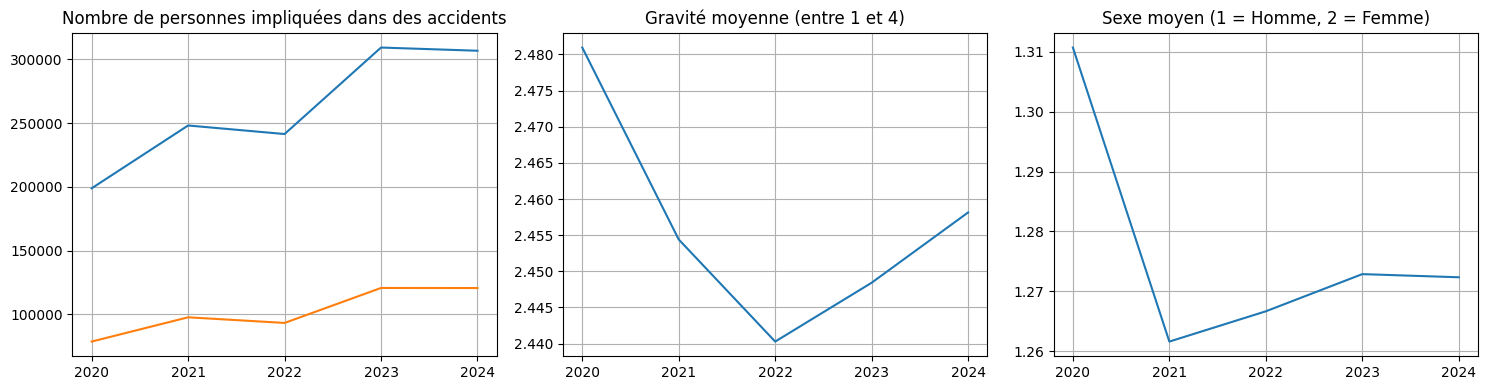

In [167]:
liste_df = [globals()[f'df_{i}'] for i in range(2020, 2025)]
annees = [i for i in range(2020, 2025)]
occurences, occurences_graves, grav_moy, sexe_moy = graph_baac.dynamiques_temporelles(liste_df)

fig, axs = plt.subplots(1, 3, figsize=(15, 4)) 
for ax in axs : 
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


axs[0].plot(annees, occurences, label = 'accidents')
axs[0].grid(True)
axs[0].plot(annees, occurences_graves, label = 'accidents graves')
axs[0].set_title("Nombre de personnes impliquées dans des accidents")

axs[1].plot(annees, grav_moy)
axs[1].grid(True)
axs[1].set_title("Gravité moyenne (entre 1 et 4)")

axs[2].plot(annees, sexe_moy)
axs[2].grid(True)
axs[2].set_title("Sexe moyen (1 = Homme, 2 = Femme)")

plt.tight_layout()
plt.show()


A remplir

On plot 3 graphes en fonction des années : le nombre de personnes impliquées dans des accidents de la route, la gravité moyenne qui est un entier variant entre 1 et 4 et le sexe moyenne qui est un entier (1 pour les hommes, 2 pour les femmes). Descprition des graphes : augmentation du nombre de victimes d'accidents et d'accidents graves depuis 2020 de x% et y%. Peut-être du a une reprise de l'activité depuis le covid, car en réalité depuis 2005 diminution (de z%, source INSEE ...). La gravité moyenne a peu évolué a cours de la période (décrire les évolutions) et le sexe moyen passe de tant à tant. (il faut calculer x y z et l'évolution du sexe moyen) 

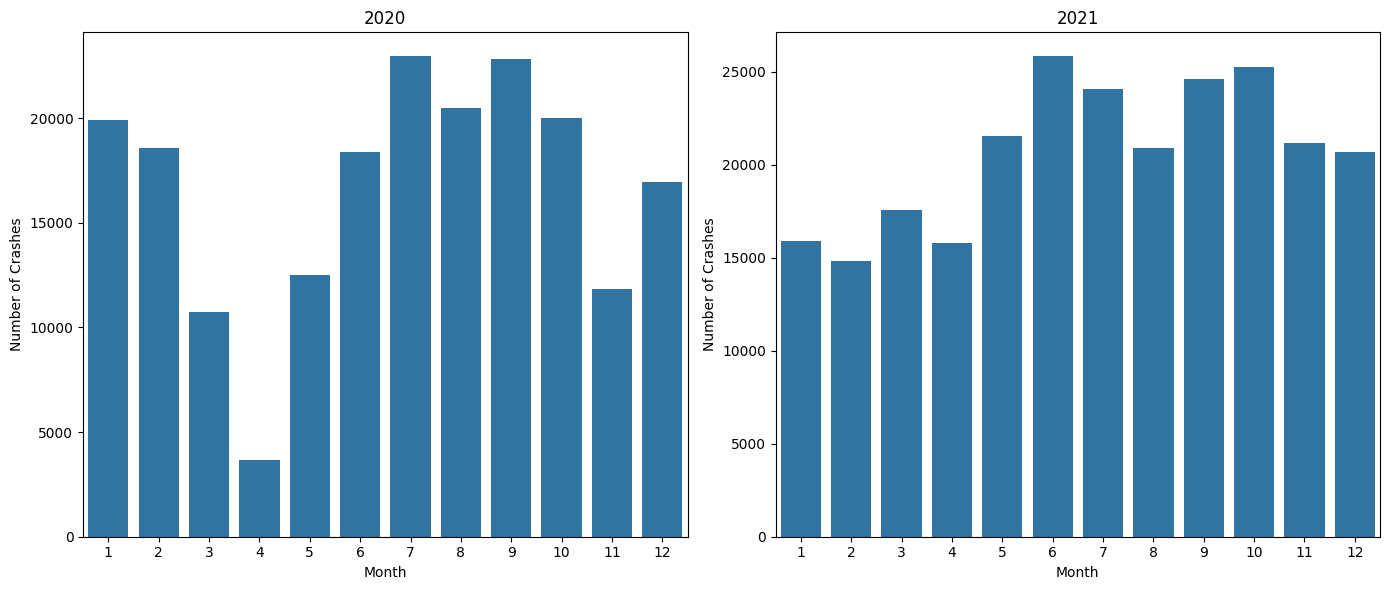

In [ ]:
dfs = [df_2020, df_2021]
graph_baac.plot_multiple(dfs, graph_baac.plot_crashes_per_month, ['2020', '2021'])

A remplir

On a plot l'histogramme du nombre de victimes par mois sur une année pour les années 2020 et 2021
Les creux correspondent précisement aux confinements liés au COVID. Les histogrammes associés aux autres années sont plus réguliers. Globalement, l'évolution temporelle des variables est faible. 

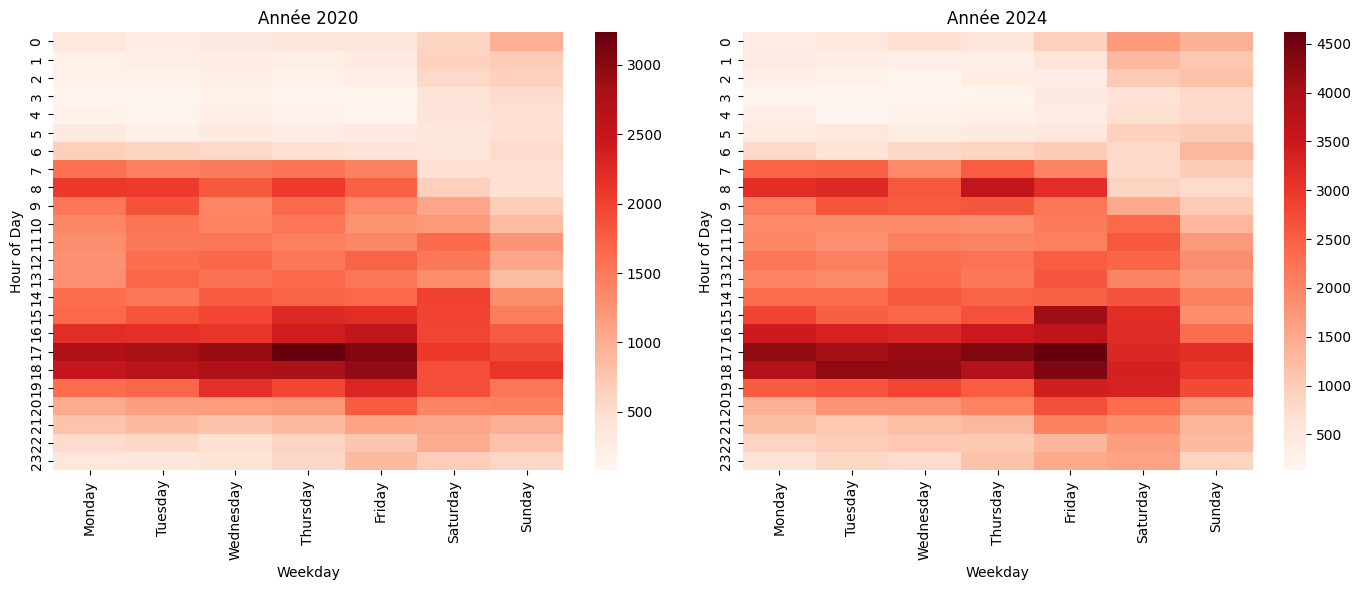

In [ ]:
dfs = [df_2020, df_2024]
graph_baac.plot_multiple(dfs, graph_baac.plot_accidents_heatmap_cote_a_cote, ['Année 2020', 'Année 2024'])

A remplir

Si l'on observe une différence en termes de quantité de victimes d'accident de la route, la fréquence d'accident par jour de la semaine et heure de la journée reste similaire. Les pics par heure correspondent aux pics de fatigue du corps humain (théoriquement 5h et 16h, ici plutôt 7/8h et 16/17h, ce qui correspond aux horaires de travail) avec un pic le vendredi en fin de semaine et une diminution nette le week-end.

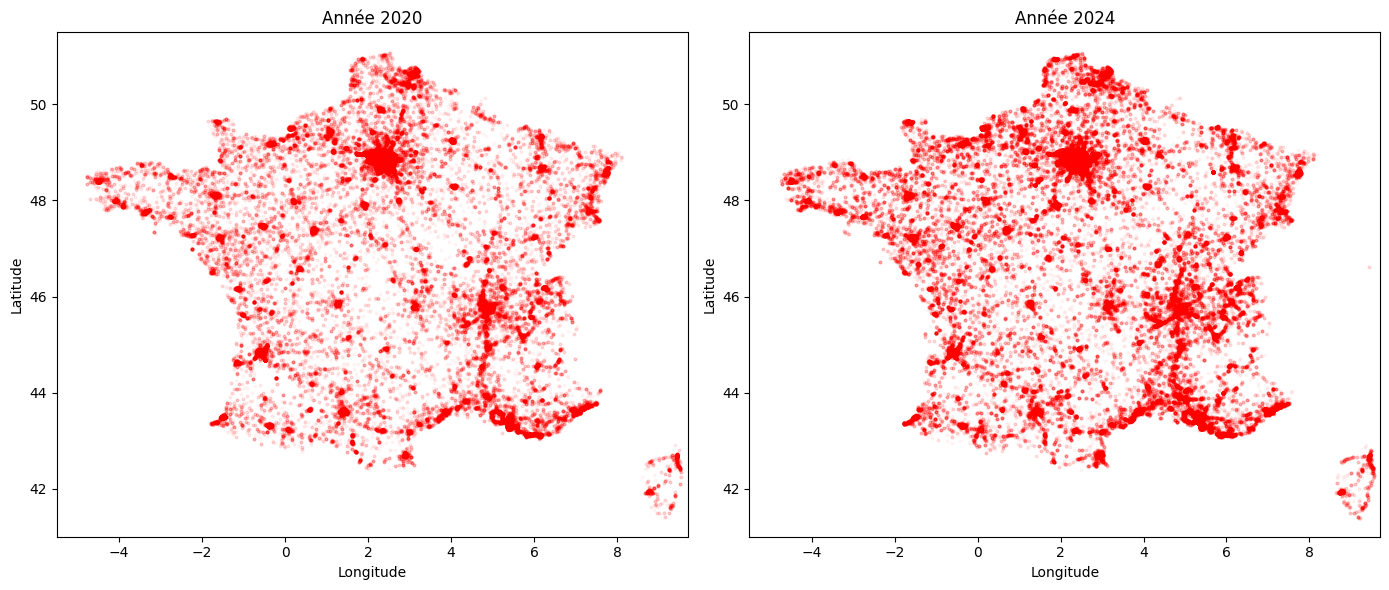

In [129]:

graph_baac.plot_multiple(dfs, graph_baac.plot_crashes_heatmap_cote_a_cote, titles)

A remplir

Enfin, cette heatmap permet de finir de constater que le nombre a augmenté au cours des 5 dernières années, mais la répartition est globalement la même. C'est pourquoi dans la suite de l'étde on se concentrera sur le dataset lié à l'année 2024.

## II. Analyse exploratoire multivariée  

A remplir

L'objectif principal de ce projet est de comprendre les facteurs liés au risque d'accident sur la route. On se propose dans un premier temps d'observer les données de manière exploratoire à l'aide d'analyses en composantes principales. Dans un premier temps en conservant toutes les variables, puis en extrayant les variables expliquant le mieux la variance, et en les combinant avec les variables que l'on considère pertinentes pour observer les corrélations entre elles. Enfin on effectuera une régression multivariée afin d'exliquer la gravité de l'accident. 

### ACP prenant en compte toutes les variables

Explained variance ratio:
[0.16648503 0.09260511 0.0857926 ]
Cumulative variance explained:
[0.16648503 0.25909014 0.34488274]


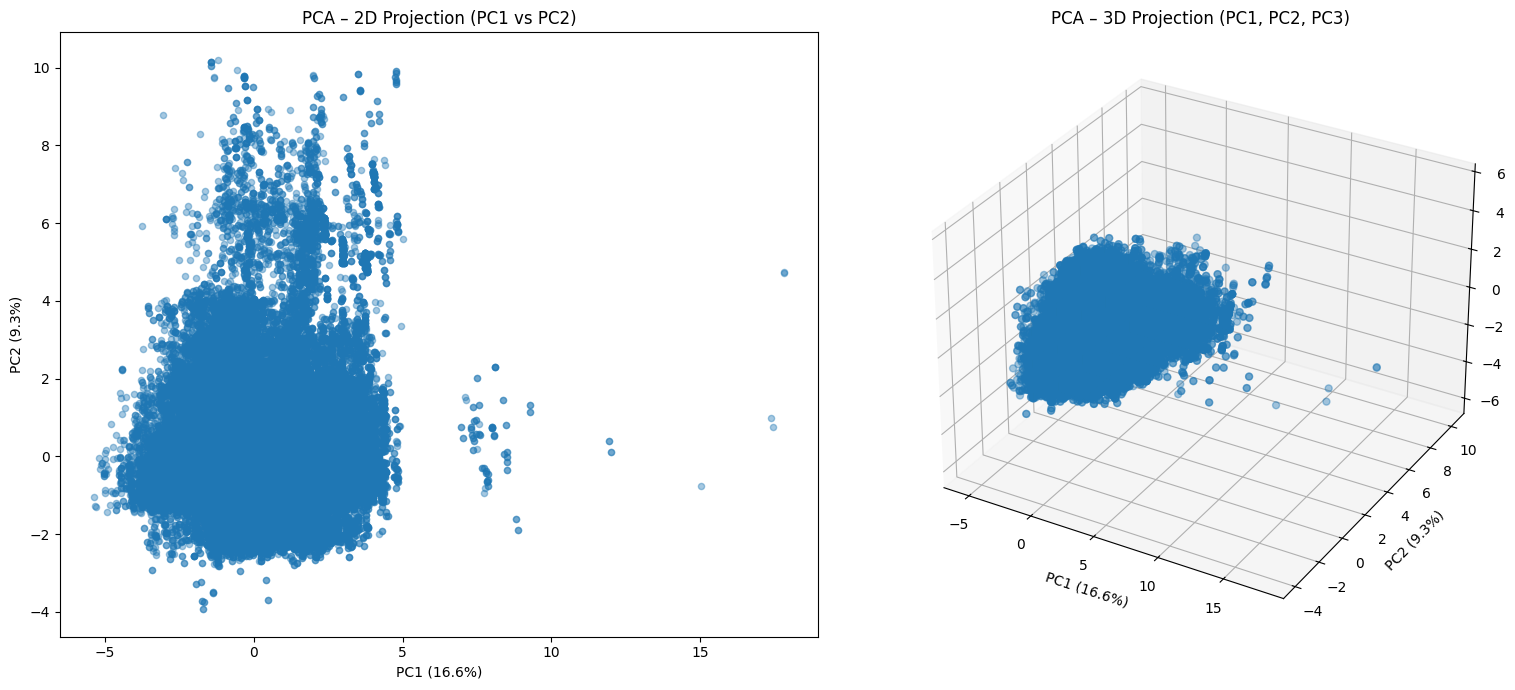

In [ ]:
pca, pca_df = graph_baac.plot_pca_2D_3D(df_2024)

A remplir

wtf

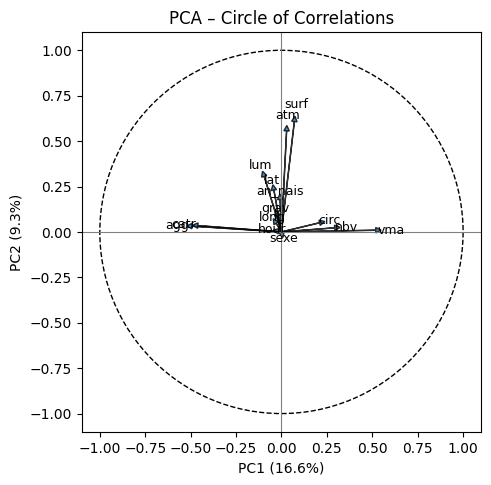

In [150]:
graph_baac.plot_correlation_circle(pca, pca_df.columns)

In [145]:
a, b, significant_variables = graph_baac.pca_analysis(pca, pca_df, 0.1)

Correlation of variables with PCs:
           PC1    PC2    PC3
grav    -0.047  0.136  0.252
hour    -0.068  0.013  0.288
lat     -0.072  0.296 -0.114
long    -0.068  0.083 -0.027
agg     -0.797  0.038  0.140
vma      0.838  0.011  0.012
nbv      0.493  0.028  0.346
catr    -0.748  0.042  0.009
circ     0.365  0.065  0.265
lum     -0.159  0.381  0.564
atm      0.046  0.667 -0.352
surf     0.114  0.726 -0.213
sexe     0.014 -0.034 -0.019
an_nais -0.013  0.237  0.586

Cos² (quality of representation):
           PC1    PC2    PC3  sum_PC1_PC2
grav     0.002  0.018  0.063        0.021
hour     0.005  0.000  0.083        0.005
lat      0.005  0.088  0.013        0.093
long     0.005  0.007  0.001        0.012
agg      0.635  0.001  0.019        0.637
vma      0.702  0.000  0.000        0.702
nbv      0.243  0.001  0.120        0.244
catr     0.560  0.002  0.000        0.561
circ     0.133  0.004  0.070        0.138
lum      0.025  0.145  0.318        0.170
atm      0.002  0.446  0.124     

A remplir

Constater les oppositions entre variables, et observer les variables contribuant beaucoup aux composantes principales
Bien préciser que les variables contribuant peu ne sont pas inintéressantes, et qu'il est logique que des variables pouvant prendre plus de valeurs que celles qui nous intéressent telles que la gravité (4) ou encore le sexe (2) soient de norme faible puisque leur variance sera naturellement plus faible que celle d'une autre comme la vitesse maximale autorisée. 

### ACP ciblée

Explained variance ratio:
[0.3237807  0.22163861 0.20157394]
Cumulative variance explained:
[0.3237807  0.54541931 0.74699325]


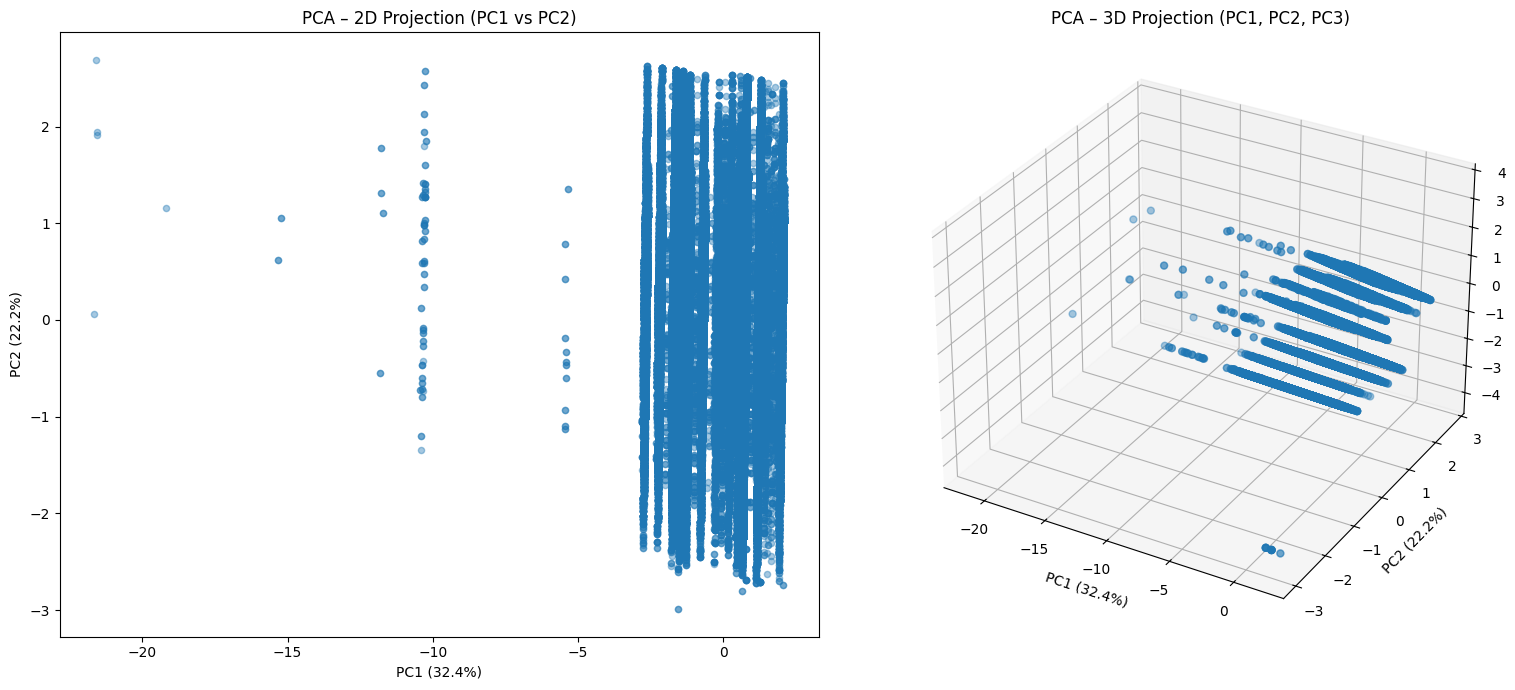

In [160]:
pca_s, pca_df_s = graph_baac.plot_pca_2D_3D(df_2024, ['an_nais', 'grav', 'vma', 'sexe', 'agg'])

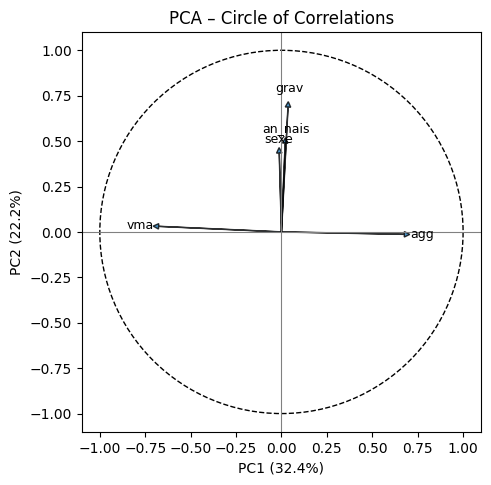

In [161]:
graph_baac.plot_correlation_circle(pca_s, pca_df_s.columns)

A remplir

La vitesse maximale autorisée est opposée au fait d'habiter en agglomération. La gravité de l'accident est positivement corrélée au sexe, et à l'année de naissance, ce qui signifie que les jeunes sont plus gravement touchés. 

Sur la représentation graphique de l'ACP, les individus sont répartis en couches séparés 